## MOSAIKS feature extraction

This tutorial demonstrates the **MOSAIKS** method for extracting _feature vectors_ from satellite imagery patches for use in downstream modeling tasks. It will show:
- How to extract 1km$^2$ patches of Sentinel 2 multispectral imagery for a list of latitude, longitude points
- How to extract summary features from each of these imagery patches
- How to use the summary features in a linear model of the population density at each point

### Background

Consider the case where you have a dataset of latitude and longitude points assosciated with some dependent variable (for example: population density, weather, housing prices, biodiversity) and, potentially, other independent variables. You would like to model the dependent variable as a function of the independent variables, but instead of including latitude and longitude directly in this model, you would like to include some high dimensional representation of what the Earth looks like at that point (that hopefully explains some of the variance in the dependent variable!). From the computer vision literature, there are various [representation learning techniques](https://en.wikipedia.org/wiki/Feature_learning) that can be used to do this, i.e. extract _features vectors_ from imagery. This notebook gives an implementation of the technique described in [Rolf et al. 2021](https://www.nature.com/articles/s41467-021-24638-z), "A generalizable and accessible approach to machine learning with global satellite imagery" called Multi-task Observation using Satellite Imagery & Kitchen Sinks (**MOSAIKS**). For more information about **MOSAIKS** see the [project's webpage](http://www.globalpolicy.science/mosaiks).


**Notes**:
- This example uses [Sentinel-2 Level-2A data](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). The techniques used here apply equally well to other remote-sensing datasets.
- If you're running this on the [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute), make sure to choose the **GPU - PyTorch** profile when presented with the form to choose your environment.

In [ ]:
# installs dask-geopandas
#!pip install -q git+https://github.com/geopandas/dask-geopandas

In [1]:

import warnings
import time
import os
import gc
import calendar
from IPython.display import FileLink

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# contextily package to retrieve tile maps
import contextily as ctx
import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
import dask.dataframe as dd
from dask.distributed import Client
import dask_gateway

warnings.filterwarnings(action="ignore", category=UserWarning, module="torch")

import pystac_client
import planetary_computer as pc



In [2]:
# number to features to be generated from each satellite tile fed into the MOSAIKS process
num_features = 1000

# specifies which of the many satellites to use
satellite = "sentinel-2-l2a"

# the code for Zambia in MPC STAC syntax
country_code = 'ZMB'

# this decisdes if you generate points to featurize within this notebook or you pull them from another notebook
# use_file = True
use_file = False

## Create grid and sample points to featurize

In [3]:
%%time
if use_file:
    gdf = pd.read_feather('data/keep/ZMB_crop_weights_20k-points.feather')
    gdf = (
        geopandas
        .GeoDataFrame(
            gdf, 
            geometry = geopandas.points_from_xy(x = gdf.lon, y = gdf.lat), 
            crs='EPSG:4326')
    )
else:
    
    ### get country shape in a vector form from a Zambian border geojson file
    country_file_name = "~/PlanetaryComputerExamples/Capstone/Featurization/geoBoundaries-ZMB-ADM0-all(1)/geoBoundaries-ZMB-ADM0_simplified.geojson"
    zambia = geopandas.read_file(country_file_name)
        ### Read in the shapefile for the sea polyggon
    gdf_sea = geopandas.read_file('~/PlanetaryComputerExamples/Capstone/Featurization/RALS_shapefiles/Joint_Rals.shp', crs = 'EPSG:4326')
    
    
    
    ### Create grid of points that will be laid over Zambia
    
    cell_size = .01  # 0.01 is roughly a 1 km
    
    xmin, ymin, xmax, ymax = gdf_sea.total_bounds
    
    xs = list(np.arange(xmin, xmax + cell_size, cell_size))
    ys = list(np.arange(ymin, ymax + cell_size, cell_size))
    
    def make_cell(x, y, cell_size):
        ring = [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y + cell_size),
            (x, y + cell_size)
        ]
        cell = shapely.geometry.Polygon(ring).centroid
        return cell


CPU times: user 68.3 ms, sys: 12 ms, total: 80.3 ms
Wall time: 79.3 ms


In [20]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=2, maximum=50)
print(cluster.dashboard_link)


https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.93b83be7198c4608aa3bf267c6e7e314/status


In [19]:
cluster.close()

In [21]:
%%time
# initiates an empty vector
center_points = []
    
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        center_points.append(cell)

    
### Put grid into a GeDataFrame for cropping to country shape
gdf = geopandas.GeoDataFrame({'geometry': center_points}, crs = 'EPSG:4326')
gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y

# convert GeoDataFrame to Dask GeoDataFrame
dask_gdf = dask_geopandas.from_geopandas(gdf, npartitions=47)

# use Dask to apply the within() method in parallel
dask_gdf_within = dask_gdf.map_partitions(
    lambda partition: partition[partition.geometry.within(zambia.unary_union)],
    meta=gdf.head(0)
)

# convert Dask GeoDataFrame back to GeoDataFrame
gdf_within = dask_gdf_within.compute()

CPU times: user 40.9 s, sys: 288 ms, total: 41.2 s
Wall time: 2min 7s


2023-02-25 21:03:35,504 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1310, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/t

<AxesSubplot:>

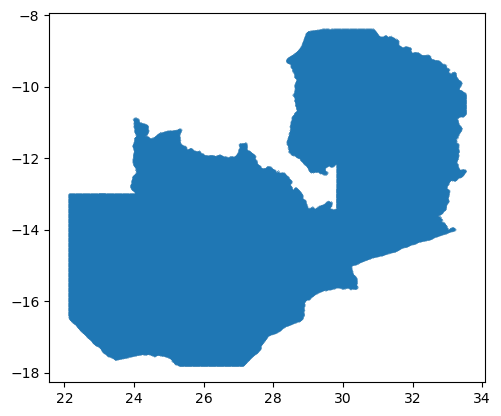

In [22]:
gdf_within.plot(markersize = 0.01)



In [23]:
gdf = gdf_within
gdf.to_csv(f'points_zambia.csv', index = False)

In [ ]:

print(gdf.crs)
print(gdf_sea.crs)

In [15]:
if gdf.crs != gdf_sea.crs:
    gdf = gdf.to_crs(gdf_sea.crs)
    print(gdf.crs)

mask = gdf.within(gdf_sea.unary_union)
gdf = gdf[mask]

epsg:9707


KeyboardInterrupt: 

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

In [6]:
class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""
    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__()
        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0, "Please enter an even number of features."
        # Applies a 2D convolution over an input image composed of several input planes.
        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )
        # Fills the input Tensor 'conv1.weight' with values drawn from the normal distribution
        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0) 
        # Fills the input Tensor 'conv1.bias' with the value 'val = -1'.
        nn.init.constant_(self.conv1.bias, -1.0)
    def forward(self, x):
        # The rectified linear activation function or ReLU for short is a piecewise linear function 
        # that will output the input directly if it is positive, otherwise, it will output zero.
        x1a = F.relu(self.conv1(x), inplace=True)
        # The below step is where we take the inverse which is appended later
        x1b = F.relu(-self.conv1(x), inplace=True)
        # Applies a 2D adaptive average pooling over an input signal composed of several input planes.
        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()
        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

Next, we initialize the model and pytorch components

In [7]:
device = torch.device("cuda")
model = RCF(num_features).eval().to(device)

### Extract features from the imagery around each point

We need to find a suitable Sentinel 2 scene for each point. As usual, we'll use `pystac-client` to search for items matching some conditions, but we don't just want do make a `.search()` call for each of the 67,968 remaining points. Each HTTP request is relatively slow. Instead, we will *batch* or points and search *in parallel*.

We need to be a bit careful with how we batch up our points though. Since a single Sentinel 2 scene will cover many points, we want to make sure that points which are spatially close together end up in the same batch. In short, we need to spatially partition the dataset. This is implemented in `dask-geopandas`.

So the overall workflow will be

1. Find an appropriate STAC item for each point (in parallel, using the spatially partitioned dataset)
2. Feed the points and STAC items to a custom Dataset that can read imagery given a point and the URL of a overlapping S2 scene
3. Use a custom Dataloader, which uses our Dataset, to feed our model imagery and save the corresponding features

In [11]:
NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

# deletes these items from memmory to free up space
del ddf
del hd
del gdf

gc.collect()

NameError: name 'gdf' is not defined

In [ ]:
%%time
year_start = 2015
year_end = 2021
print(
    "Using:\n", 
    f"  {satellite} imagery \n",
    f"  Looking for monthly images for {pt_len} points \n",
    f"  Calulating {num_features} features \n",
    f"  between {year_start} and {year_end} \n")
for yr in range(year_start, year_end+1):
    features = pd.DataFrame()
    ft = []
    if (yr == 2015) :
        month_range = range(7, 13)
    else:
        month_range = range(1, 13)
        
    for mn in month_range:
        if mn < 10:
            month = "0"+str(mn)
        else:
            month = mn
        def query(points):
            """
            Find a STAC item for points in the `points` DataFrame
            
            Parameters
            ----------
            points : geopandas.GeoDataFrame
                A GeoDataFrame
                
            Returns
            -------
            geopandas.GeoDataFrame
                A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
                item that covers each point.
            """
            intersects = shapely.geometry.mapping(points.unary_union.convex_hull)
            
            catalog = pystac_client.Client.open(
                "https://planetarycomputer.microsoft.com/api/stac/v1"
            )
            # Define search date range for query
            ending_day = calendar.monthrange(yr, int(mn))[1]
            search_start = f"{yr}-{month}-1" 
            search_end = f"{yr}-{month}-{ending_day}" 
            
            # The time frame in which we search for non-cloudy imagery
            search = catalog.search(
                collections=[satellite],
                intersects=intersects,
                datetime=[search_start, search_end],
                query={"eo:cloud_cover": {"lt": 10}},
                limit=500,
            )
            ic = search.get_all_items_as_dict()
            features = ic["features"]
            features_d = {item["id"]: item for item in features}
            data = {
                "eo:cloud_cover": [],
                "geometry": [],
            }
            index = []
            for item in features:
                data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
                data["geometry"].append(shapely.geometry.shape(item["geometry"]))
                index.append(item["id"])
            items = geopandas.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
                "eo:cloud_cover"
            )
            point_list = points.geometry.tolist()
            point_items = []
            for point in point_list:
                covered_by = items[items.covers(point)]
                if len(covered_by):
                    point_items.append(features_d[covered_by.index[0]])
                else:
                    # There weren't any scenes matching our conditions for this point (too cloudy)
                    point_items.append(None)
            return points.assign(stac_item=point_items)
        
        tic = time.time()
        print("Matching images to points for: ", mn, "-", yr, sep = "")
        
        with Client(n_workers=16) as client:
            meta = dgdf._meta.assign(stac_item=[])
            df2 = dgdf.map_partitions(query, meta=meta).compute()
        df3 = df2.dropna(subset=["stac_item"])
        matching_urls = [
            pc.sign(item["assets"]["visual"]["href"]) for item in df3.stac_item.tolist()
        ]
        points = df3[["lon", "lat"]].to_numpy()
        
        print("Found acceptable images for ", 
              points.shape[0], 
              " points in ", 
              f"{time.time()-tic:0.2f} seconds", 
              sep = "")
        
        class CustomDataset(Dataset):
            def __init__(self, points, fns, buffer=0.005):
                self.points = points
                self.fns = fns
                self.buffer = buffer
            def __len__(self):
                return self.points.shape[0]
            def __getitem__(self, idx):
                lon, lat = self.points[idx]
                fn = self.fns[idx]
                if fn is None:
                    return None
                else:
                    point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
                    with rasterio.Env():
                        with rasterio.open(fn, "r") as f:
                            point_shape = shapely.geometry.shape(point_geom)
                            mask_shape = point_shape.buffer(self.buffer).envelope
                            mask_geom = shapely.geometry.mapping(mask_shape)
                            mask_geom = rasterio.warp.transform_geom(
                                "epsg:4326", f.crs.to_string(), mask_geom
                            )
                            try:
                                out_image, out_transform = rasterio.mask.mask(
                                    f, [mask_geom], crop=True
                                )
                            except ValueError as e:
                                if "Input shapes do not overlap raster." in str(e):
                                    return None
                    out_image = out_image / 255.0
                    out_image = torch.from_numpy(out_image).float()
                    return out_image
        dataset = CustomDataset(points, matching_urls)
        dataloader = DataLoader(
            dataset,
            batch_size=8,
            shuffle=False,
            num_workers=os.cpu_count()*2,
            collate_fn=lambda x: x,
            pin_memory=False,
        )
        x_all = np.zeros((points.shape[0], num_features), dtype=float)
        tic = time.time()
        i = 0
        print("Featurizing: ", month, "-", yr, sep = "")
        for images in dataloader:
            for image in images:
                if i % 1000 == 0:
                    print(
                        f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                        + f" -- {time.time()-tic:0.2f} seconds"
                    )
                    tic = time.time()
                if image is not None:
                    # A full image should be ~101x101 pixels (i.e. ~1km^2 at a 10m/px spatial
                    # resolution), however we can receive smaller images if an input point
                    # happens to be at the edge of a S2 scene (a literal edge case). To deal
                    # with these (edge) cases we crudely drop all images where the spatial
                    # dimensions aren't both greater than 20 pixels.
                    if image.shape[1] >= 20 and image.shape[2] >= 20:
                        image = image.to(device)
                        with torch.no_grad():
                            feats = model(image.unsqueeze(0)).cpu().numpy()
                        x_all[i] = feats
                    else:
                        # this happens if the point is close to the edge of a scene
                        # (one or both of the spatial dimensions of the image are very small)
                        pass
                else:
                    pass  # this happens if we do not find a S2 scene for some point
                i += 1
        features_monthly = pd.DataFrame(x_all)
        features_monthly[["lon", "lat"]] = points.tolist()
        features_monthly['year'] = yr
        features_monthly['month'] = mn
        
        ft.append(features_monthly)
        
        # Free memory before loop iterates
        print("Freeing RAM")
        del meta
        del query
        del df2
        del df3
        del points
        del dataset
        del dataloader
        del x_all
        del features_monthly
        del CustomDataset
        del matching_urls
        gc.collect()
        print('')
        
    features = pd.concat(ft).reset_index(drop = True)
    
    features.columns = features.columns.astype(str)
    # Save the features to a feather file
    file_name = (f'data/{satellite}_bands-3-4-5_{country_code}_{pt_len/1000:.0f}'+
                 f'k-points_{num_features}-features_{yr}.feather')
    
    print("Saving file as:", file_name)
    features.to_feather(file_name)
    
    # display(FileLink(file_name))
    
    print("Save finished!")
    # Free memory before loop iterates
    print("Freeing RAM")
    del features
    del ft
    gc.collect()
    print('')

Using:
   sentinel-2-l2a imagery 
   Looking for monthly images for 6940 points 
   Calulating 1000 features 
   between 2015 and 2021 

Matching images to points for: 7-2015
Found acceptable images for 528 points in 21.12 seconds
Featurizing: 07-2015
0/528 -- 0.00% -- 0.72 seconds
Freeing RAM

Matching images to points for: 8-2015
Found acceptable images for 1133 points in 20.96 seconds
Featurizing: 08-2015
0/1133 -- 0.00% -- 0.76 seconds
1000/1133 -- 88.26% -- 6.99 seconds
Freeing RAM

Matching images to points for: 9-2015
Found acceptable images for 4132 points in 23.23 seconds
Featurizing: 09-2015
0/4132 -- 0.00% -- 1.17 seconds
1000/4132 -- 24.20% -- 7.46 seconds
2000/4132 -- 48.40% -- 6.54 seconds
3000/4132 -- 72.60% -- 8.61 seconds
4000/4132 -- 96.81% -- 6.06 seconds
Freeing RAM

Matching images to points for: 10-2015
Found acceptable images for 2272 points in 20.26 seconds
Featurizing: 10-2015
0/2272 -- 0.00% -- 0.80 seconds
1000/2272 -- 44.01% -- 7.64 seconds
2000/2272 -- 88.0